# Training des RNN
Import der verwendeten Pakete

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

from settings.Authentication import Authentication
from service.DataService import DataService
from service.ThingsBoardClientLight import ThingsBoardClientLight

### Einstellungen für das Speichern der Bilddateien

In [30]:
save_plot = False
fontsize = 14
y_lim = 2.6,4.1

### Initialisieren der Settings und der Serviceklassen
Hinweis: In der Klasse Authentications müssen URL, Benutzername und passwort hinterlegt werden, um eine erfolgreiche Verbindung zur REST-API herstellen zu können.

In [31]:
# initialize ThingsBoardClient
ds = DataService()
auth = Authentication()
tc = ThingsBoardClientLight(username=auth.USERNAME, api_url=auth.URL,
                          password=auth.PASSWORD)

### Konvertieren der extrahierten Spannungsverlaufsdaten der Sensoren in Pandas DataFrames
In diesem Schritt wird ein großteil der Datenaufbereitung umgesetzt. Die pickle_to_pandas_dataframe-Methode der Klasse DataService, lädt die extrahierten Spannungsverlaufsdaten aus der Datenanalyse, und konvertiert sie, für jeden Schlüssel der Liste key_list, in separate Pandas DataFrames. Dabei werden spezifische Datenbereinigungen durchgeführt, wie die Konvertierung von Werten in numerische Formate, Bereinigung von Einheiten und Zeitstempeln. Die DataFrames werden zu einem DataFrame konkateniert nach dem optional weitere Datentransformationen, wie Resampling, Rolling Means und Imputation, durchgeführt wurden.

Hinweis: Um weitere Sensoren in die Trainingsdaten mit aufzunehmen, müssten die Spannungsverlaufsdaten der Sensoren an dieser Stelle extrahiert und analog zu den gezeigten Datensätzen eingebunden werden

In [25]:
# telemetry to PandasDataframe
df_325723 = ds.pickle_to_pandas_dataframe('6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce_Thesis_extended_newm_RAW',
                                         ['data_BatV', 'data_rssi', 'data_snr'],
                                         missing_values='lag_impute')
df_325733 = ds.pickle_to_pandas_dataframe('3f394130-a5f9-11ed-8fa7-8d95df41b8ce_Thesis_extended_newm_RAW',
                                         ['data_BatV', 'data_rssi', 'data_snr'],
                                         missing_values='lag_impute')

### Darstellung der aufbereiteten Spannungsverlaufskurven aus dem Ergebnis der pickle_to_pandas_dataframe() Methode

<Axes: xlabel='ts'>

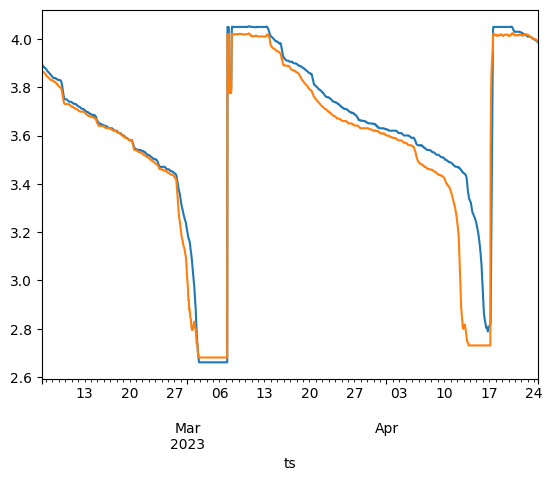

In [27]:
df_325723['rm_data_BatV'].plot()
df_325733['rm_data_BatV'].plot()

### Ausschneiden der einzelnen Spannungsverlaufskurven
Die einzelnen Spannungsverlaufskurven werden zunächst manuell aus den zuvor aufbereiteten Datensätzen extrahiert und anschließend der Methode create_full_curve_thesis() der DataService-Klasse übergeben, um sie vorzuverarbeiten. In dieser Methode werden der Beginn und das Ende der Kurven markiert und die Datenpunkte auf eine einheitliche Anzahl an Datenpunkten aufgefüllt. Optional kann angegeben werden, ob es sich um einen Testdatensatz handelt, bei dem das Ende der Kurve nicht markiert wird.

Hinweis: An dieser Stelle wäre eine Automatisierung sinnvoll, welche die einzelnen Spannungsverlaufskurven automatisiert aus den PandasDataFrames ausschneidet.

In [6]:
# create full_curves for given datasets
df_325723_full_curve = ds.create_full_curve_thesis(df_325723, 'data_BatV')

df_325723_full_curve_1 = df_325723.loc[df_325723['data_BatV'].idxmax():].copy()
df_325723_full_curve_1 = df_325723_full_curve_1[20:]
df_325723_full_curve_1 = ds.create_full_curve_thesis(df_325723_full_curve_1, 'data_BatV')

df_325733_full_curve = ds.create_full_curve_thesis(df_325733, 'data_BatV')
df_325733_full_curve_1 = df_325733.loc[df_325733['data_BatV'].idxmax():].copy()
df_325733_full_curve_1 = df_325733_full_curve_1[20:]
df_325733_full_curve_1 = ds.create_full_curve_thesis(df_325733_full_curve_1, 'data_BatV')

### Darstellung des Ergebnisses der Datenvorverarbeitung

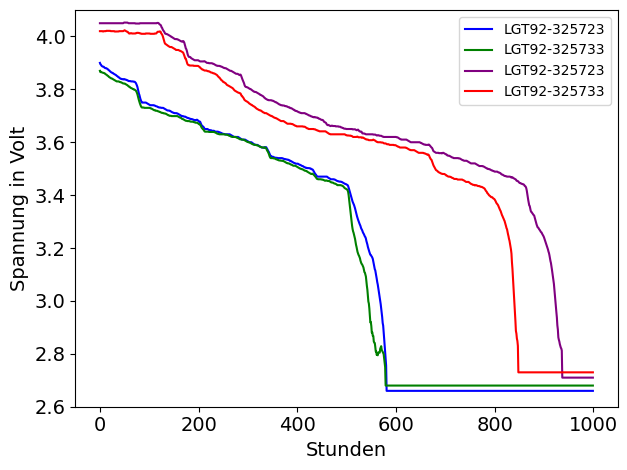

In [7]:
df_325723_full_curve['rm_data_BatV'].plot(color='blue', label='LGT92-325723')
df_325733_full_curve['rm_data_BatV'].plot(color='green', label='LGT92-325733')
df_325723_full_curve_1['rm_data_BatV'].plot(color='purple', label='LGT92-325723')
df_325733_full_curve_1['rm_data_BatV'].plot(color='red', label='LGT92-325733')
df_325723_full_curve.tail()
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/four_single_curves', pad_inches=2)

### Konkatenieren der einzelnen Spannungsverlaufskurven in ein Pandas DataFrame (Trainingsdatensatz)
Die einzelnen Spannungsverlaufskurven werden zu einem einzelnen Pandas DataFrame zusammen geführt, das resultierenden DataFrame wird mit einem neuen Zeitstempel von einer Stunde versehen.

In [8]:
df_train = pd.concat([df_325723_full_curve, df_325723_full_curve_1, df_325733_full_curve, df_325733_full_curve_1], ignore_index=True)
my_date_range = pd.date_range(end=df_325723.index[-1], periods=len(df_train), freq='H')
df_train['date'] = my_date_range
df_train.set_index('date', inplace=True)
df_train.fillna(0, inplace=True)
df_train.index.freq = 'H'

### Darstellung des konkatenierten Trainingsdatensatzes

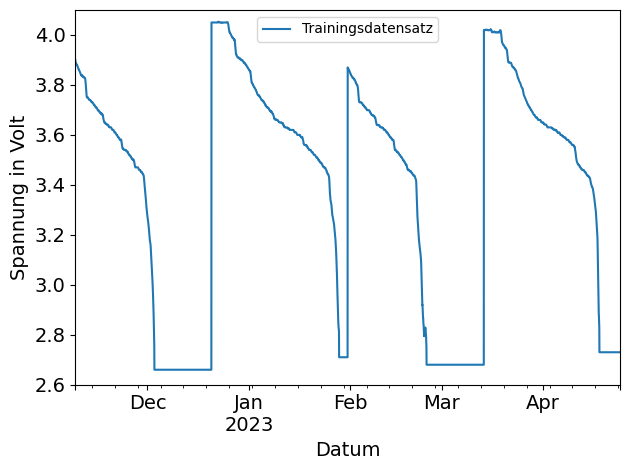

In [9]:
df_train['rm_data_BatV'].plot(label='Trainingsdatensatz')
plt.xlabel('Datum', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/Trainingsdatensatz', pad_inches=2)

### Umstrukturierung und Standardisierung des Trainingsdatensatzes für RNN-LSTM
In diesem Abschnitt werden die Trainingsdaten vorbereitet, indem sie in den X- und y-Datensätzen aufgeteilt und standardisiert werden. Anschließend werden die Daten für die Verwendung mit einem RNN-Modell umstrukturiert.

In [10]:
# prepare data
X_train_raw = df_train[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_train_raw = df_train[['rm_data_BatV']].values

### Standardisierung von X
scaler_x = scaler = StandardScaler()
scaler_x.fit(X_train_raw)
X_train_std = scaler_x.transform(X_train_raw)
dump(scaler_x, '../../data/scaler/train_scaler_thesis_x.joblib')

### Standardisierung von y
scaler_y = StandardScaler()
scaler_y.fit(y_train_raw)
y_train_std = scaler_y.transform(y_train_raw)
dump(scaler_y, '../../data/scaler/train_scaler_thesis_y.joblib')

print(X_train_std.shape)

### set the window size, horizon of the prediction, as well as the number of features
window = 24
horizon = 1
indicators = 5

# restructure data for LSTM of customTB client
X_train, y_train = ds.restructure_data_for_lstm(X_train_std, y_train_std, window=window, horizon=horizon)

X_train.shape, y_train.shape

(4000, 5)


((3975, 24, 5), (3975, 1))

### Ausschneiden und Aufbereiten des Testdatensatzes LGT92-325723
Vorgehen analog zum Trainingsdatensatz

In [11]:
df_325723_test = df_325723[-140:]
df_325723_test = ds.create_full_curve_thesis(df_325723_test, 'data_BatV', test=True)

### Darstellung des Testdatensatzes LGT92-325723

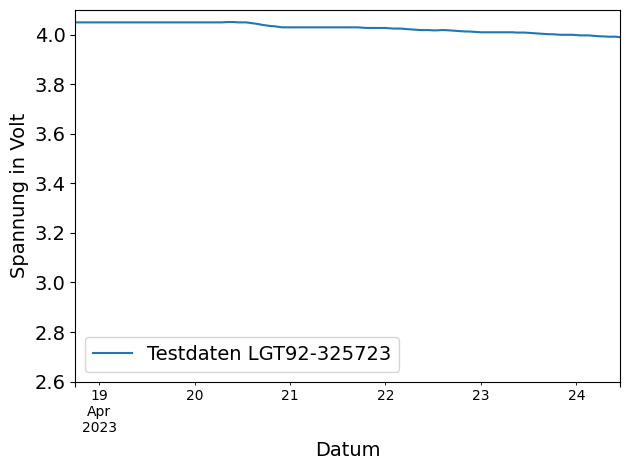

In [12]:
df_325723_test['rm_data_BatV'].plot(label='Testdaten LGT92-325723')
plt.xlabel('Datum', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/test_data_LGT92-325723', pad_inches=2)

### Ausschneiden und Aufbereiten des Testdatensatzes LGT92-325733
Vorgehen analog zum Trainingsdatensatz

In [13]:
df_325733_test = df_325733[-145:]
df_325733_test = ds.create_full_curve_thesis(df_325733_test, 'data_BatV', test=True)

### Darstellung des Testdatensatzes LGT92-325733

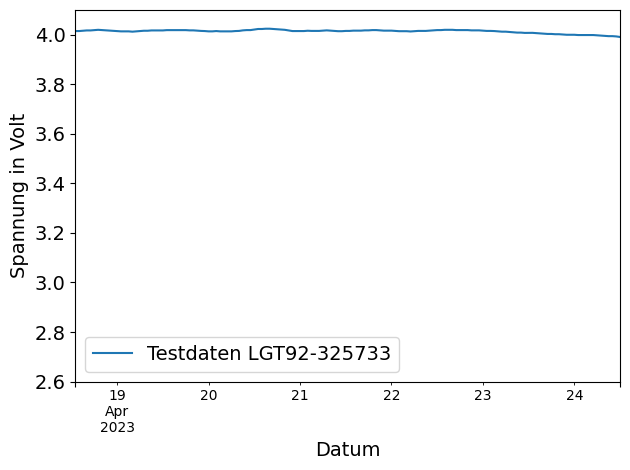

In [14]:
df_325733_test['rm_data_BatV'].plot(label='Testdaten LGT92-325733')
plt.legend()
plt.xlabel('Datum', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/test_data_LGT92-325733', pad_inches=2)

### Hinzufügen der jeweils anderen SensorID zu den Testdatensätzen

In [15]:
df_325723_test[df_325733_full_curve['sensor_id'][0]] = 0
df_325733_test[df_325723_full_curve['sensor_id'][0]] = 0

### Umstrukturierung und Standardisierung des Testdatensatzes LGT92-315723
In diesem Abschnitt werden die Testdaten LGT92-315723 vorbereitet, indem sie in den X- und y-Datensätzen aufgeteilt und standardisiert werden. Anschließend werden die Daten für die Verwendung mit einem RNN-Modell umstrukturiert.

In [16]:
X_test_23_raw = df_325723_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_23_raw = df_325723_test[['rm_data_BatV']].values

X_test_23_std = scaler_x.transform(X_test_23_raw)
y_test_23_std = scaler_y.transform(y_test_23_raw)

X_23_test, y_23_test = ds.restructure_data_for_lstm(X_test_23_std, y_test_23_std, window=window, horizon=horizon)

### Umstrukturierung und Standardisierung des Testdatensatzes LGT92-315733
In diesem Abschnitt werden die Testdaten LGT92-315733 vorbereitet, indem sie in den X- und y-Datensätzen aufgeteilt und standardisiert werden. Anschließend werden die Daten für die Verwendung mit einem RNN-Modell umstrukturiert.

In [17]:
X_test_33_raw = df_325733_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_33_raw = df_325733_test[['rm_data_BatV']].values

X_test_33_std = scaler_x.transform(X_test_33_raw)
y_test_33_std = scaler_y.transform(y_test_33_raw)

X_33_test, y_33_test = ds.restructure_data_for_lstm(X_test_33_std, y_test_33_std, window=window, horizon=horizon)

### Aufbau des RNN-Modells mit LSTM-Zellen

In [18]:
batch_size = 32
model = Sequential()
model.add(LSTM(units=64, dropout=.2, input_shape=(window, indicators), return_sequences=True))
model.add(LSTM(units=64, dropout=.2))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

2023-06-14 12:33:33.592032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-14 12:33:33.592315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________


### Training des Modells
Training des Modells unter verwendung der Callback-Funktionen EarlyStopping() und ModelCheckpoint()

Hinweis: Die Ergebnisse des Trainings können auf verschiedenen Plattformen variieren, da Keras-Modelle mit zufälligen Gewichten initialisiert werden. Dies führt zu unterschiedlichen Startpunkten auf der Verlustfunktion und kann die Anzahl der benötigten Epochen und die Art der Verlaufskurven beeinflussen.

In [19]:
## TO TRAIN
early = EarlyStopping(monitor='val_loss', patience=9)
check = ModelCheckpoint(filepath='../../data/model/train_model_thesis.h5',
                        monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train,
                    epochs=100, batch_size=batch_size,
                    validation_data=(X_23_test, y_23_test),
                    callbacks=[early, check])

Epoch 1/100


2023-06-14 12:33:33.929788: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-14 12:33:34.707131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:33:34.881209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:33:35.009298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:33:35.147465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/125 [..............................] - ETA: 3s - loss: 0.8228 - mae: 0.7811  

2023-06-14 12:33:35.361609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 0.0697 - mae: 0.1314

2023-06-14 12:33:38.697431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:33:38.753312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:33:38.823995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 5s 29ms/step - loss: 0.0697 - mae: 0.1314 - val_loss: 2.4752e-04 - val_mae: 0.0119
Epoch 2/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0265 - mae: 0.0766 - val_loss: 5.5232e-04 - val_mae: 0.0207
Epoch 3/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0226 - mae: 0.0696 - val_loss: 2.5996e-04 - val_mae: 0.0140
Epoch 4/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0194 - mae: 0.0570 - val_loss: 1.2030e-04 - val_mae: 0.0086
Epoch 5/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0223 - mae: 0.0621 - val_loss: 0.0010 - val_mae: 0.0301
Epoch 6/100
125/125 [==============================] - 3s 22ms/step - loss: 0.0165 - mae: 0.0465 - val_loss: 0.0045 - val_mae: 0.0664
Epoch 7/100
125/125 [==============================] - 3s 21ms/step - loss: 0.0184 - mae: 0.0512 - val_loss: 0.0012 - val_mae: 0.0332
Epoch 8/100
125/125 [==============================] - 3s 

### Darstellung des Trainingsverlaufs anhand der Loss-Kurve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


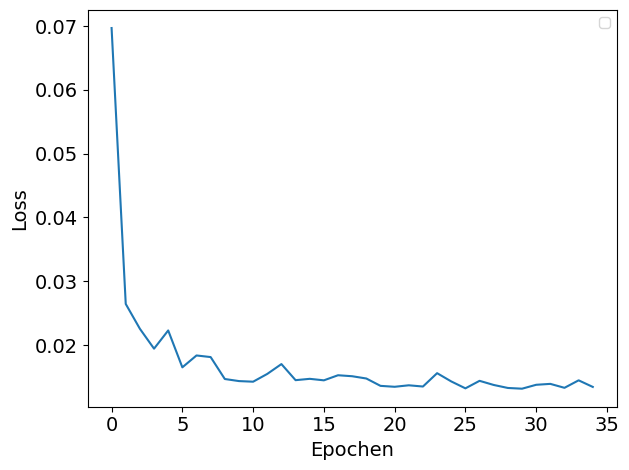

In [20]:
loss_mse = history.history['loss']
plt.plot(loss_mse)
plt.xlabel('Epochen', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/loss_model_thesis', pad_inches=2)

### Prädiktion über die Trainingsdaten
Hier wird das trainierte Modell geladen und über den Trainingsdatensatz und eine Prädiktion für die Trainingsdaten erzeugt. Das Ergebnis wird visualisiert

2023-06-14 12:35:10.375323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:35:10.431476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:35:10.510079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 2s 9ms/step
[[3.877672 ]
 [3.868419 ]
 [3.8670244]
 ...
 [2.7173436]
 [2.7173436]
 [2.7173436]]


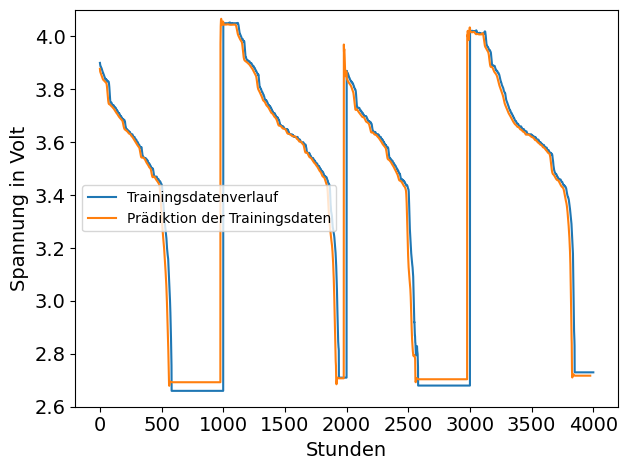

In [21]:
model = load_model('../../data/model/train_model_thesis.h5')

### Mit Neuronalem Netz (Achtung: die y-Vorhersagen müssen reskaliert werden (wegen Standardisierung))
y_pred = model.predict(X_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

print(y_pred_inv)

plt.plot(np.linspace(1, len(y_train_raw), len(y_train_raw)), y_train_raw,
         label='Trainingsdatenverlauf')
plt.plot(np.linspace(1, len(y_pred_inv), len(y_pred_inv)), y_pred_inv,
         label='Prädiktion der Trainingsdaten')
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/predict_train_model_thesis', pad_inches=2)
plt.show()

### Prädiktion und (Evaluation) über den Testdatensatz LGT92-325723

4/4 [==============================] - 0s 33ms/step


2023-06-14 12:35:12.190818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:35:12.243587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-14 12:35:12.317269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 40ms/step - loss: 7.2332e-05 - mae: 0.0071


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE:  0.007086360361427069


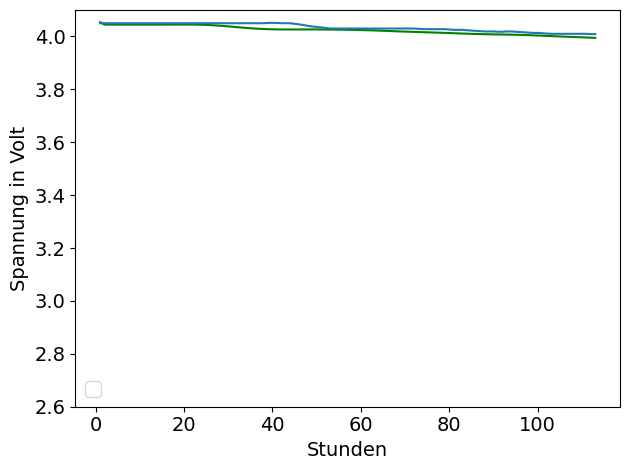

In [22]:
y_pred_test = model.predict(X_23_test)
y_pred_test_23_inv = scaler_y.inverse_transform(y_pred_test)

# Evaluating the model on a test data set
evaluate = model.evaluate(X_23_test, y_23_test)
# Metrics output
print('MAE: ', evaluate[1])

plt.plot(np.linspace(1, len(y_pred_test_23_inv), len(y_pred_test_23_inv)), y_pred_test_23_inv, color='green')
plt.plot(np.linspace(1, len(y_test_23_raw[:len(y_pred_test)]), len(y_test_23_raw[:len(y_pred_test)])), y_test_23_raw[:len(y_pred_test)])
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/test_predict_testdata_23', pad_inches=2)
plt.show()

### Prädiktion und (Evaluation) über den Testdatensatz LGT92-325733

4/4 [==============================] - 0s 40ms/step - loss: 7.9276e-05 - mae: 0.0071


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE:  0.00712938979268074


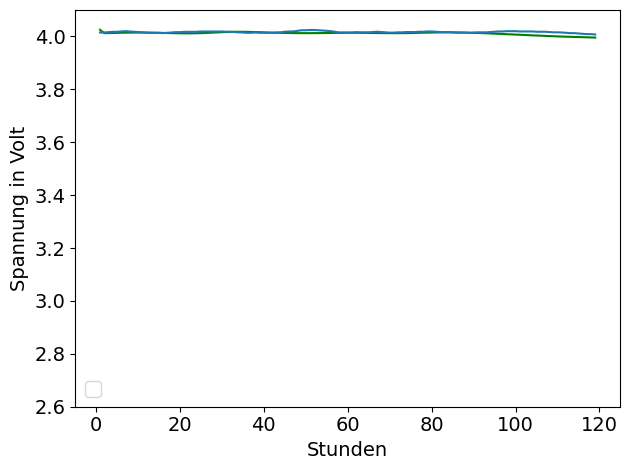

In [23]:
y_pred_test = model.predict(X_33_test)

# Evaluating the model on a test data set
evaluate = model.evaluate(X_33_test, y_33_test)
# Metrics output
print('MAE: ', evaluate[1])

y_pred_test_33_inv = scaler_y.inverse_transform(y_pred_test)
plt.plot(np.linspace(1, len(y_pred_test_33_inv), len(y_pred_test_33_inv)), y_pred_test_33_inv, color='green')
plt.plot(np.linspace(1, len(y_test_33_raw[:len(y_pred_test)]), len(y_test_33_raw[:len(y_pred_test)])), y_test_33_raw[:len(y_pred_test)])
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.tight_layout()
if save_plot:
    plt.savefig(f'../../data/png/test_predict_testdata_23', pad_inches=2)
plt.show()